In [ ]:
# 1. IMPORT THƯ VIỆN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
warnings.filterwarnings("ignore")


In [ ]:
# 2. ĐỌC DỮ LIỆU & XỬ LÝ BAN ĐẦU
file_path = "data_HN.csv"
df = pd.read_csv(file_path)

print(df)

             date  is_weekend  is_holiday admin_type      district  \
0      01/01/2022        True        True       Quận       Ba Đình   
1      01/01/2022        True        True       Quận     Hoàn Kiếm   
2      01/01/2022        True        True       Quận  Hai Bà Trưng   
3      01/01/2022        True        True       Quận       Đống Đa   
4      01/01/2022        True        True       Quận        Tây Hồ   
...           ...         ...         ...        ...           ...   
31779  31/12/2024       False       False      Huyện       Ứng Hòa   
31780  31/12/2024       False       False      Huyện    Thường Tín   
31781  31/12/2024       False       False      Huyện     Phú Xuyên   
31782  31/12/2024       False       False      Huyện       Mê Linh   
31783  31/12/2024       False       False      Huyện       Sơn Tây   

       population  area_km2  vehicle_count  temperature  rainfall  humidity  \
0          221893        92          45195          261        84        75   
1

Mô tả biến:

    date: Ngày quan sát

    is_weekend: có phải ngày cuối tuần không ?

    is_holiday: Có phải ngày nghỉ lễ không ?

    admin_type: Loại địa bàn: Huyện / Quận

    district: Tên quận/huyện

    population: Dân số của quận/huyện

    area_km2: Diện tích (km²) của quận/huyện

    vehicle_count: Số lượng phương tiện (tổng hợp)

    temperature: Nhiệt độ

    rainfall: Lượng mưa (mm)

    air_quality: chỉ số chất lượng không khí

    special_event:
    
    ngày lễ:
        1: new year
        2: Cultural Festival
        3: Market Day
        4: Road Construction
        5: Sports Event
        6: Government Meeting

    traffic_congestion_level: Mức độ ùn tắc

In [ ]:
# 4. Kiểm tra các dòng còn thiếu dữ liệu
missing_data = df.isnull().sum()
print("Các cột có dữ liệu thiếu:\n", missing_data[missing_data > 0])

Các cột có dữ liệu thiếu:
 special_event    87
dtype: int64


In [ ]:
#Xử lý ngoại lệ đơn giản:
# - Loại bỏ dòng có nhiệt độ bất thường (<100 hoặc >450, tương đương 10°C đến 45°C)
df = df[(df['temperature'] >= 100) & (df['temperature'] <= 450)]

In [ ]:
#Chuyển đổi định dạng cột 'date' sang kiểu datetime
df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')

#Đảm bảo các cột boolean đúng kiểu
bool_columns = ['is_weekend', 'is_holiday']
for col in bool_columns:
    df[col] = df[col].astype(bool)

Trực quan hóa

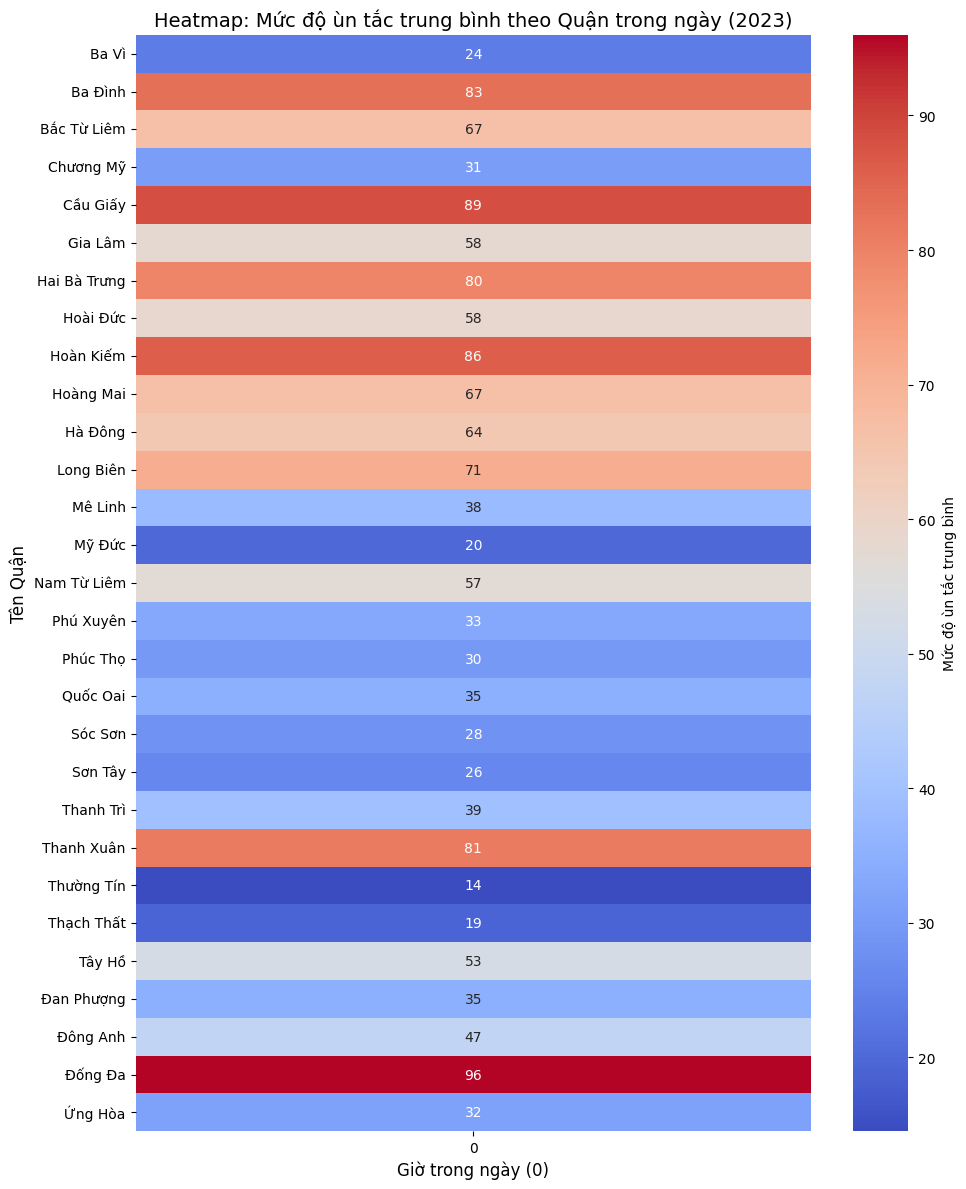

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tính mức độ ùn tắc trung bình theo từng quận
avg_congestion_by_district = df.groupby("district")["traffic_congestion_level"].mean().sort_values(ascending=False)

# Chuyển sang DataFrame cho phù hợp với heatmap
heatmap_data = pd.DataFrame(avg_congestion_by_district).reset_index()
heatmap_data.columns = ["Tên Quận", "Mức độ ùn tắc trung bình"]

# Chuẩn bị lại dữ liệu để tạo heatmap có 1 cột giờ cố định (ví dụ: giờ = 0)
heatmap_data["Giờ"] = 0
heatmap_pivot = heatmap_data.pivot(index="Tên Quận", columns="Giờ", values="Mức độ ùn tắc trung bình")

# Vẽ heatmap
plt.figure(figsize=(10, 12))
sns.heatmap(heatmap_pivot, annot=True, fmt=".0f", cmap="coolwarm", cbar_kws={'label': 'Mức độ ùn tắc trung bình'})
plt.title("Heatmap: Mức độ ùn tắc trung bình theo Quận trong ngày (2023)", fontsize=14)
plt.xlabel("Giờ trong ngày (0)", fontsize=12)
plt.ylabel("Tên Quận", fontsize=12)
plt.tight_layout()
plt.show()


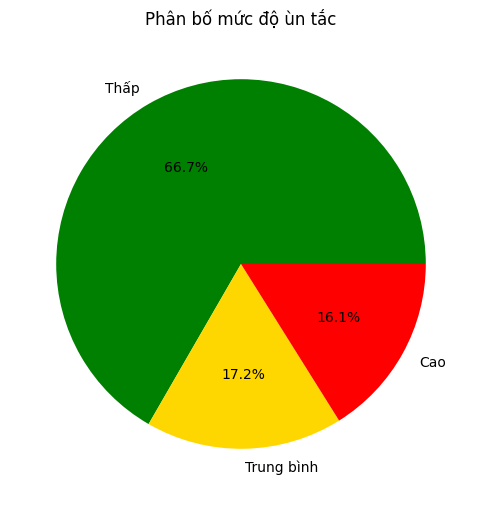

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Đọc dữ liệu
df = pd.read_csv("data_HN.csv")

# Chuyển đổi ngày về đúng kiểu, xử lý lỗi ngày không hợp lệ
df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')

# Loại bỏ các dòng có giá trị ngày bị lỗi (NaT)
df = df.dropna(subset=['date'])

# Thêm cột 'hour' giả lập nếu chưa có (vì không có sẵn trong dữ liệu)
# Nếu có cột 'hour' thật sự, có thể bỏ phần này
df['hour'] = df['date'].dt.hour  # mặc định về 0 vì không có giờ cụ thể

# Phân loại mức độ ùn tắc: 0=Thấp, 1=TB, 2=Cao (dựa theo traffic_congestion_level)
def label_congestion(x):
    if x < 60:
        return 'Thấp'
    elif x < 80:
        return 'Trung bình'
    else:
        return 'Cao'

df['level_label'] = df['traffic_congestion_level'].apply(label_congestion)

# Biểu đồ 1: Biểu đồ tròn - phân bố mức độ ùn tắc
plt.figure(figsize=(6, 6))
pie_data = df['level_label'].value_counts()
plt.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%', colors=['green', 'gold', 'red'])
plt.title('Phân bố mức độ ùn tắc')
plt.show()


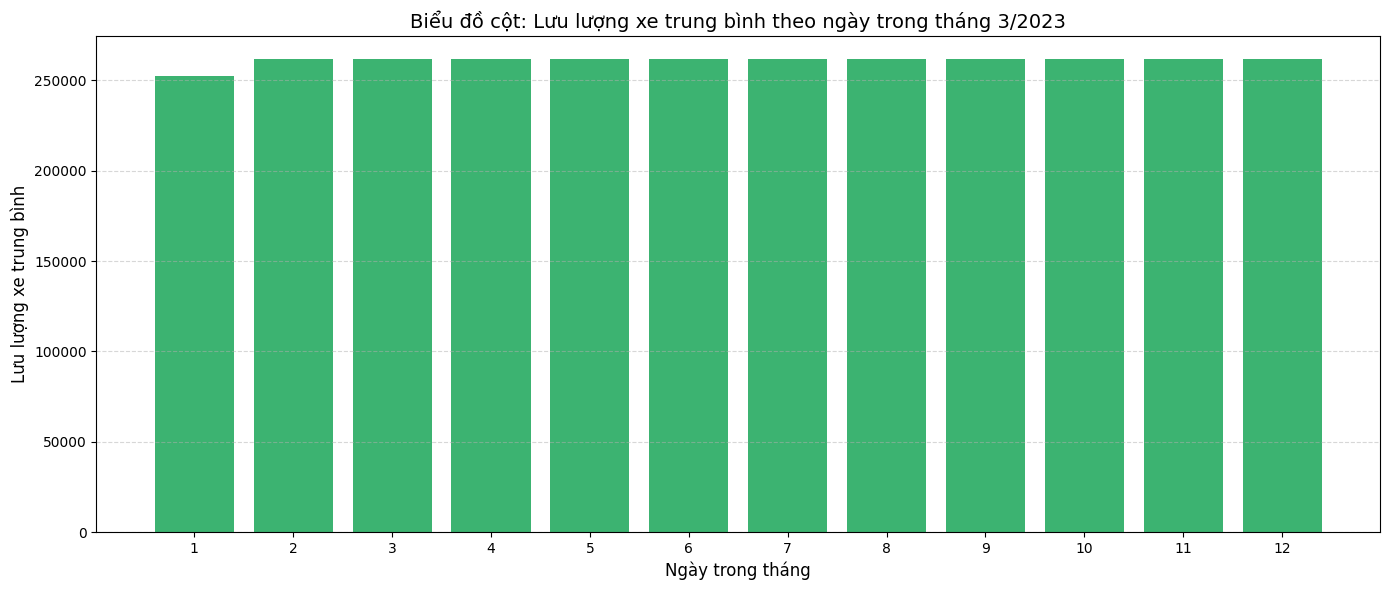

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc dữ liệu
df = pd.read_csv("data_HN.csv")

# Chuyển cột 'date' về kiểu datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

# Chọn một tháng cụ thể (ví dụ: tháng 3 năm 2023)
df_month = df[(df['date'].dt.month == 3) & (df['date'].dt.year == 2023)]

# Trích xuất ngày trong tháng
df_month['day'] = df_month['date'].dt.day

# Tính tổng hoặc trung bình lưu lượng xe mỗi ngày
daily_counts = df_month.groupby('day')['vehicle_count'].mean()

# Vẽ biểu đồ
plt.figure(figsize=(14, 6))
plt.bar(daily_counts.index, daily_counts.values, color='mediumseagreen')
plt.xticks(daily_counts.index)
plt.xlabel('Ngày trong tháng', fontsize=12)
plt.ylabel('Lưu lượng xe trung bình', fontsize=12)
plt.title('Biểu đồ cột: Lưu lượng xe trung bình theo ngày trong tháng 3/2023', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


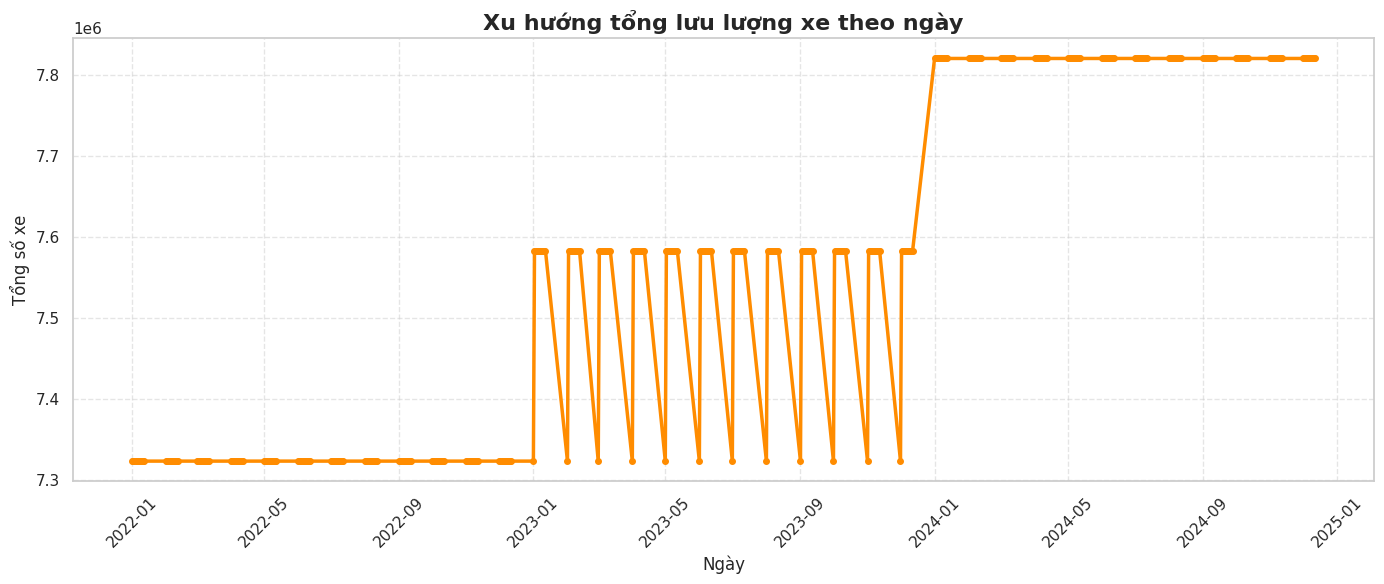

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Thiết lập phong cách biểu đồ
sns.set(style="whitegrid")

# Tạo biểu đồ đường
plt.figure(figsize=(14, 6))
line_data = df.groupby('date')['vehicle_count'].sum()

# Vẽ đường với hiệu ứng nổi bật
plt.plot(line_data.index, line_data.values, color='darkorange', linewidth=2.5, marker='o', markersize=4)

# Thêm các chi tiết cải thiện thẩm mỹ
plt.title('Xu hướng tổng lưu lượng xe theo ngày', fontsize=16, fontweight='bold')
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Tổng số xe', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# BƯỚC 1: Đọc và chuẩn bị dữ liệu
df = pd.read_csv("data_HN.csv")
df = df.dropna()  # Loại bỏ dòng thiếu dữ liệu

# BƯỚC 2: Xác định đặc trưng đầu vào và nhãn đầu ra
# Đặc trưng đầu vào: những yếu tố ảnh hưởng đến ùn tắc
features = ['vehicle_count', 'temperature', 'humidity', 'rainfall']
X = df[features]

# Nhãn (label): mức độ ùn tắc (do con người hoặc cảm biến gán sẵn)
y = df['traffic_congestion_level']  # 0 = thấp, 1 = TB, 2 = cao

# BƯỚC 3: Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# BƯỚC 4: Huấn luyện mô hình Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# BƯỚC 5: Dự đoán trên tập kiểm tra và đánh giá hiệu quả
y_pred = model.predict(X_test)

# In báo cáo phân loại: độ chính xác, precision, recall, F1
print("🔍 KẾT QUẢ DỰ ĐOÁN UNG TẮC (Phân loại):")
print(classification_report(y_test, y_pred))


🔍 KẾT QUẢ DỰ ĐOÁN UNG TẮC (Phân loại):
              precision    recall  f1-score   support

          12       1.00      1.00      1.00       151
          13       1.00      1.00      1.00        76
          14       1.00      1.00      1.00        78
          16       1.00      1.00      1.00        79
          17       1.00      1.00      1.00       150
          18       1.00      1.00      1.00       135
          19       1.00      1.00      1.00       147
          20       1.00      1.00      1.00        79
          21       1.00      1.00      1.00       163
          23       0.99      0.97      0.98       205
          24       1.00      1.00      1.00        77
          26       1.00      1.00      1.00        65
          30       1.00      1.00      1.00        65
          32       1.00      1.00      1.00        84
          34       1.00      1.00      1.00       152
          35       1.00      1.00      1.00       213
          37       1.00      1.00      1.0

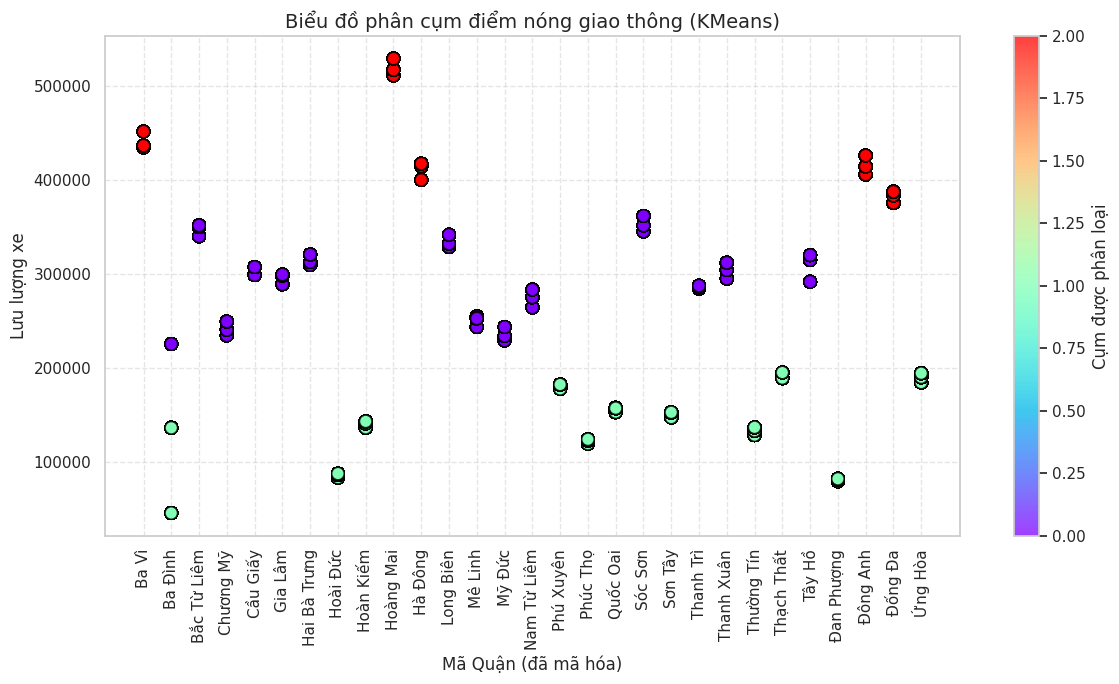

In [ ]:
# Reload after environment reset
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Load data again
df = pd.read_csv("data_HN.csv")
df = df.dropna()

# Encode district names into numerical codes
df['district_code'] = df['district'].astype('category').cat.codes
district_labels = dict(enumerate(df['district'].astype('category').cat.categories))

# Prepare clustering input data
X_cluster = df[['district_code', 'vehicle_count']]

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_cluster)

# Improved visualization of clusters
plt.figure(figsize=(12, 7))
scatter = plt.scatter(
    df['district_code'],
    df['vehicle_count'],
    c=df['cluster'],
    cmap='rainbow',
    edgecolor='black',
    s=80,
    alpha=0.75
)

plt.xlabel("Mã Quận (đã mã hóa)", fontsize=12)
plt.ylabel("Lưu lượng xe", fontsize=12)
plt.title("Biểu đồ phân cụm điểm nóng giao thông (KMeans)", fontsize=14)
plt.colorbar(label='Cụm được phân loại')
plt.xticks(ticks=range(len(district_labels)), labels=list(district_labels.values()), rotation=90)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Gắn nhãn phân loại cho mức độ ùn tắc
def classify_congestion(level):
    if level < 33:
        return 0  # Thấp
    elif level < 66:
        return 1  # Trung bình
    else:
        return 2  # Cao

df['congestion_class'] = df['traffic_congestion_level'].apply(classify_congestion)

# Chọn đặc trưng
features = ['is_weekend', 'is_holiday', 'population', 'area_km2',
            'vehicle_count', 'temperature', 'rainfall', 'humidity',
            'air_quality', 'special_event']
X = df[features]
y = df['congestion_class']

# Tách dữ liệu train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Huấn luyện mô hình
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Đánh giá mô hình
y_pred = model.predict(X_test)
print("Báo cáo phân loại:\n", classification_report(y_test, y_pred, target_names=["Thấp", "Trung bình", "Cao"]))
print("Ma trận nhầm lẫn:\n", confusion_matrix(y_test, y_pred))


Báo cáo phân loại:
               precision    recall  f1-score   support

        Thấp       1.00      1.00      1.00       596
  Trung bình       1.00      1.00      1.00      1153
         Cao       1.00      1.00      1.00       740

    accuracy                           1.00      2489
   macro avg       1.00      1.00      1.00      2489
weighted avg       1.00      1.00      1.00      2489

Ma trận nhầm lẫn:
 [[ 596    0    0]
 [   0 1153    0]
 [   0    0  740]]


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.2090 - mae: 0.4095 - val_loss: 0.1840 - val_mae: 0.4003
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1814 - mae: 0.3909 - val_loss: 0.1676 - val_mae: 0.3732
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1685 - mae: 0.3734 - val_loss: 0.1434 - val_mae: 0.3337
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1354 - mae: 0.3144 - val_loss: 0.1054 - val_mae: 0.2831
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0951 - mae: 0.2609 - val_loss: 0.0921 - val_mae: 0.2464
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0625 - mae: 0.2061 - val_loss: 0.0400 - val_mae: 0.1638
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0323 - mae: 0.1435 - val_loss: 0.0296 - val_mae: 0.1142
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0209 - mae: 0.1052 - val_loss: 0.0227 - val_mae: 0.1017
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0187 - ma

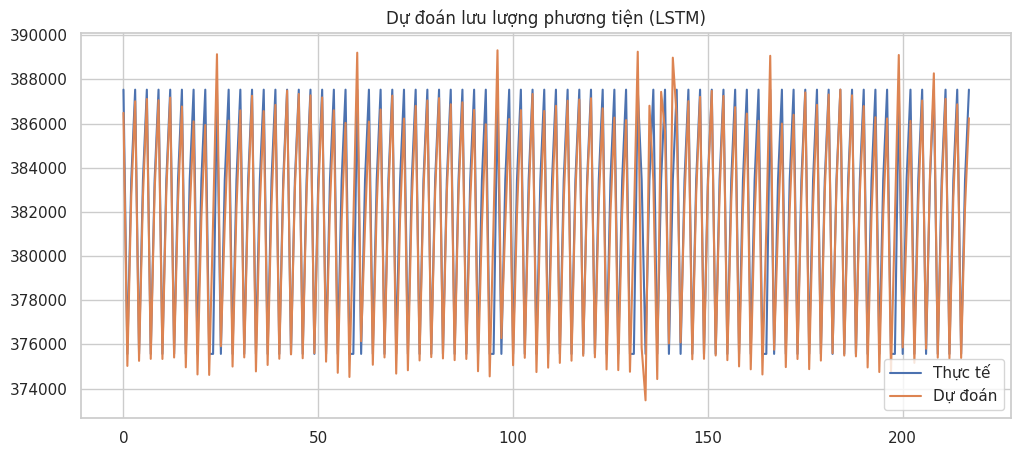

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Đọc dữ liệu
df = pd.read_csv("data_HN.csv")


# Chọn một quận cụ thể
df_dd = df[df['district'] == 'Đống Đa'].sort_values('date')
df_dd = df_dd[['vehicle_count', 'temperature', 'rainfall', 'humidity']]

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_dd)

# Hàm tạo chuỗi cho LSTM
def create_sequences(data, lookback=10):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback][0])  # vehicle_count
    return np.array(X), np.array(y)

lookback = 10
X, y = create_sequences(scaled, lookback)
split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Xây dựng mô hình LSTM
model = Sequential([
    LSTM(64, input_shape=(lookback, X.shape[2])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

# Dự đoán
y_pred = model.predict(X_test)

# Chuyển ngược lại giá trị thực
y_pred_inv = scaler.inverse_transform(
    np.hstack([y_pred, np.zeros((y_pred.shape[0], scaled.shape[1] - 1))])
)[:, 0]

y_test_inv = scaler.inverse_transform(
    np.hstack([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled.shape[1] - 1))])
)[:, 0]

# Đánh giá
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print("MAE:", mae)
print("RMSE:", rmse)

# Vẽ biểu đồ dự đoán
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label='Thực tế')
plt.plot(y_pred_inv, label='Dự đoán')
plt.legend()
plt.title("Dự đoán lưu lượng phương tiện (LSTM)")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Đọc dữ liệu
df = pd.read_csv("data_HN.csv")
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])
df = df.sort_values('date')
df = df[df['date'].dt.year == 2023]  # Lọc dữ liệu năm 2023

# Tính tổng lưu lượng xe mỗi ngày
daily_data = df.groupby(df['date'].dt.date)['vehicle_count'].sum().reset_index()
daily_data.columns = ['date', 'vehicle_count']

# Chia dữ liệu thành tập huấn luyện và kiểm tra
train_size = int(len(daily_data) * 0.8)
train, test = daily_data[:train_size], daily_data[train_size:]

# -------------------- Random Forest --------------------
# Tạo đặc trưng đơn giản: ngày dưới dạng số
train_rf = train.copy()
test_rf = test.copy()
train_rf['day_num'] = np.arange(len(train_rf))
test_rf['day_num'] = np.arange(len(train_rf), len(train_rf) + len(test_rf))

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train_rf[['day_num']], train_rf['vehicle_count'])
rf_pred = rf_model.predict(test_rf[['day_num']])
rf_rmse = np.sqrt(mean_squared_error(test_rf['vehicle_count'], rf_pred))
rf_mae = mean_absolute_error(test_rf['vehicle_count'], rf_pred)

# -------------------- LSTM --------------------
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(daily_data['vehicle_count'].values.reshape(-1,1))

# Tạo dữ liệu huấn luyện và kiểm tra cho LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back):
        X.append(dataset[i:(i+look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 5
X, Y = create_dataset(scaled_data, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

train_size_lstm = int(len(X) * 0.8)
X_train, X_test = X[:train_size_lstm], X[train_size_lstm:]
Y_train, Y_test = Y[:train_size_lstm], Y[train_size_lstm:]

lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(look_back, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(X_train, Y_train, epochs=20, batch_size=1, verbose=0)

lstm_pred = lstm_model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred)
Y_test_inv = scaler.inverse_transform(Y_test.reshape(-1,1))
lstm_rmse = np.sqrt(mean_squared_error(Y_test_inv, lstm_pred))
lstm_mae = mean_absolute_error(Y_test_inv, lstm_pred)

# -------------------- Kết quả --------------------
print("So sánh hiệu suất các mô hình:")
print(f"Random Forest - RMSE: {rf_rmse:.2f}, MAE: {rf_mae:.2f}")
print(f"LSTM - RMSE: {lstm_rmse:.2f}, MAE: {lstm_mae:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
So sánh hiệu suất các mô hình:
Random Forest - RMSE: 68109.96, MAE: 17886.55
LSTM - RMSE: 70845.96, MAE: 55631.71


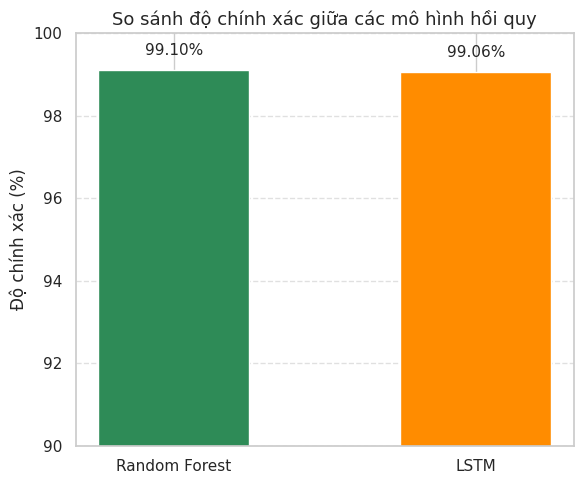

In [ ]:
import matplotlib.pyplot as plt

# Độ chính xác (ước lượng từ RMSE)
accuracy_rf = 100 * (1 - rf_rmse / daily_data['vehicle_count'].mean())
accuracy_lstm = 100 * (1 - lstm_rmse / daily_data['vehicle_count'].mean())

# Dữ liệu
models = ['Random Forest', 'LSTM']
accuracies = [accuracy_rf, accuracy_lstm]

# Vẽ biểu đồ
plt.figure(figsize=(6, 5))
bars = plt.bar(models, accuracies, width=0.5, color=['seagreen', 'darkorange'])

# Cấu hình biểu đồ
plt.ylim(90, 100)
plt.ylabel('Độ chính xác (%)', fontsize=12)
plt.title('So sánh độ chính xác giữa các mô hình hồi quy', fontsize=13)

# Hiển thị giá trị
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.3, f'{yval:.2f}%',
             ha='center', va='bottom', fontsize=11)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
